#### 运行环境 ： python2.7  TensorFlow 1.4.0

In [16]:
import tensorflow as tf

In [17]:
tf.__version__

'1.4.0'

## 7.1 TFRecord输入数据格式

### 7.1.1 TFRecord格式介绍

### 7.1.2 TFRecord样例程序

#### 将MNIST输入数据转化为TFRecord格式

In [18]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

#### 1. 将输入转化成TFRecord格式并保存。

In [19]:
# 定义函数转化变量类型。
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# 将数据转化为tf.train.Example格式。
def _make_example(pixels, label, image):
    image_raw = image.tostring()
    example = tf.train.Example(features=tf.train.Features(feature={
        'pixels': _int64_feature(pixels),
        'label': _int64_feature(np.argmax(label)),
        'image_raw': _bytes_feature(image_raw)
    }))
    return example

# 读取mnist训练数据。
mnist = input_data.read_data_sets("../data/mnist",dtype=tf.uint8, one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

# 输出包含训练数据的TFRecord文件。
with tf.python_io.TFRecordWriter("output.tfrecords") as writer:
    for index in range(num_examples):
        example = _make_example(pixels, labels[index], images[index])
        writer.write(example.SerializeToString())
print("TFRecord训练文件已保存。")

# 读取mnist测试数据。
images_test = mnist.test.images
labels_test = mnist.test.labels
pixels_test = images_test.shape[1]
num_examples_test = mnist.test.num_examples

# 输出包含测试数据的TFRecord文件。
with tf.python_io.TFRecordWriter("output_test.tfrecords") as writer:
    for index in range(num_examples_test):
        example = _make_example(
            pixels_test, labels_test[index], images_test[index])
        writer.write(example.SerializeToString())
print("TFRecord测试文件已保存。")

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz
TFRecord训练文件已保存。
TFRecord测试文件已保存。


In [20]:
mnist = input_data.read_data_sets("../data/mnist",dtype=tf.uint8, one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [21]:
print images.shape

(55000, 784)


#### 2. 读取TFRecord文件

In [9]:
# 读取文件。
reader = tf.TFRecordReader()
filename_queue = tf.train.string_input_producer(["output.tfrecords"])
_,serialized_example = reader.read(filename_queue)

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

images = tf.decode_raw(features['image_raw'],tf.uint8)
labels = tf.cast(features['label'],tf.int32)
pixels = tf.cast(features['pixels'],tf.int32)

sess = tf.Session()

# 启动多线程处理输入数据。
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess,coord=coord)

for i in range(10):
    image, label, pixel = sess.run([images, labels, pixels])

## 7.2 图像数据处理

#### Tensorflow提供了对jpeg和png格式图像的编码/解码函数。以下代码示范对jpeg格式图像进行编码/解码

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf   
import numpy as np

In [11]:
image_raw_data = tf.gfile.FastGFile("../data/cat.jpg",'rb').read()

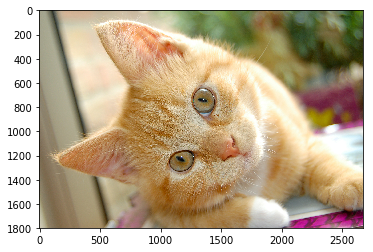

In [12]:
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    # print img_data.eval()
    plt.imshow(img_data.eval())
    plt.show()
    
    # 将表示一张图像的三维矩阵重新按照jpeg格式编码并存入到文件中。打开图像可以得到一样文件
    encoded_image = tf.image.encode_jpeg(img_data)
    with tf.gfile.GFile("../data/output","wb") as f:
        f.write(encoded_image.eval())

#### 图像大小调整

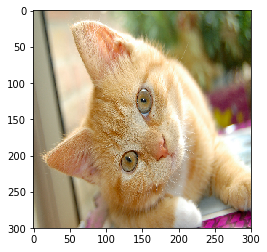

In [13]:
with tf.Session() as sess:
    # 如果直接以0-255范围的整数数据输入resize_images，那么输出将是0-255之间的实数，
    # 不利于后续处理。本书建议在调整图片大小前，先将图片转为0-1范围的实数。
    image_float = tf.image.convert_image_dtype(img_data, tf.float32)
    resized = tf.image.resize_images(image_float, [300, 300], method=0)
    
    plt.imshow(resized.eval())
    plt.show()

##### tf.image . resize_images 函数中 method 参数取值与相对应的图像大小调整算法

![1013](../TfInActionImg/1013.PNG)

#### 裁剪填充

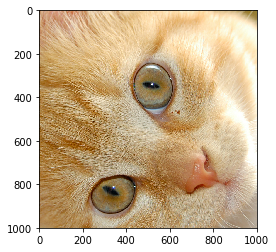

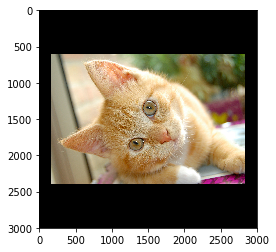

In [15]:
with tf.Session() as sess:    
    croped = tf.image.resize_image_with_crop_or_pad(img_data, 1000, 1000)
    padded = tf.image.resize_image_with_crop_or_pad(img_data, 3000, 3000)
    plt.imshow(croped.eval())
    plt.show()
    plt.imshow(padded.eval())
    plt.show()

#### 通过比例调整图像大小

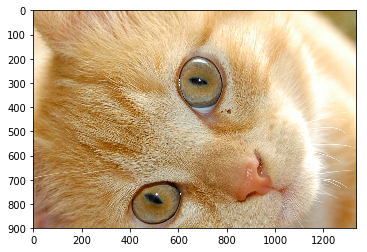

In [16]:
with tf.Session() as sess:   
    central_cropped = tf.image.central_crop(img_data, 0.5)
    plt.imshow(central_cropped.eval())
    plt.show()

#### TensorFlow 也提供了tf.image.crop_to_bounding_box 函数和 tf. image.pad_to_bounding_box 函数来剪裁或者填充给定区域的图像。

#### 图像翻转

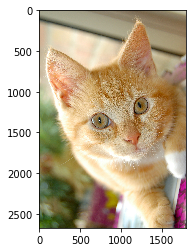

In [17]:
with tf.Session() as sess: 
    # 上下翻转
    #flipped1 = tf.image.flip_up_down(img_data)
    # 左右翻转
    #flipped2 = tf.image.flip_left_right(img_data)
    
    #对角线翻转
    transposed = tf.image.transpose_image(img_data)
    plt.imshow(transposed.eval())
    plt.show()
    
    # 以一定概率上下翻转图片。
    #flipped = tf.image.random_flip_up_down(img_data)
    # 以一定概率左右翻转图片。
    #flipped = tf.image.random_flip_left_right(img_data)

#### 注：在很多的识别场景中，图像的翻转不会影响识别的效率，所以可以随机翻转训练的图像得到不同角度的图像。

#### 图像的色彩调整：

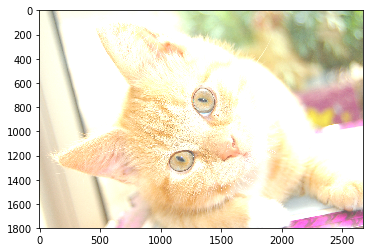

In [20]:
with tf.Session() as sess:
    # 在进行一系列图片调整前，先将图片转换为实数形式，有利于保持计算精度。
    image_float = tf.image.convert_image_dtype(img_data, tf.float32)
    
    # 将图片的亮度-0.5。
    #adjusted = tf.image.adjust_brightness(image_float, -0.5)
    
    # 将图片的亮度-0.5
    #adjusted = tf.image.adjust_brightness(image_float, 0.5)
    
    # 在[-max_delta, max_delta)的范围随机调整图片的亮度。
    adjusted = tf.image.random_brightness(image_float, max_delta=0.5)
    
    # 将图片的对比度-5
    #adjusted = tf.image.adjust_contrast(image_float, -5)
    
    # 将图片的对比度+5
    #adjusted = tf.image.adjust_contrast(image_float, 5)
    
    # 在[lower, upper]的范围随机调整图的对比度。
    #adjusted = tf.image.random_contrast(image_float, lower, upper)

    # 在最终输出前，将实数取值截取到0-1范围内。
    adjusted = tf.clip_by_value(adjusted, 0.0, 1.0)
    plt.imshow(adjusted.eval())
    plt.show()

#### 添加色相饱和度

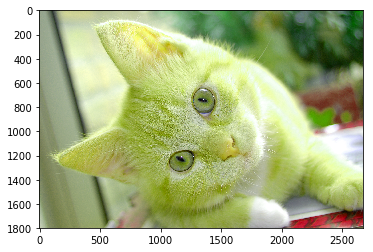

In [21]:
with tf.Session() as sess:
    # 在进行一系列图片调整前，先将图片转换为实数形式，有利于保持计算精度。
    image_float = tf.image.convert_image_dtype(img_data, tf.float32)
    
    adjusted = tf.image.adjust_hue(image_float, 0.1)
    #adjusted = tf.image.adjust_hue(image_float, 0.3)
    #adjusted = tf.image.adjust_hue(image_float, 0.6)
    #adjusted = tf.image.adjust_hue(image_float, 0.9)
    
    # 在[-max_delta, max_delta]的范围随机调整图片的色相。max_delta的取值在[0, 0.5]之间。
    #adjusted = tf.image.random_hue(image_float, max_delta)
    
    # 将图片的饱和度-5。
    #adjusted = tf.image.adjust_saturation(image_float, -5)
    # 将图片的饱和度+5。
    #adjusted = tf.image.adjust_saturation(image_float, 5)
    # 在[lower, upper]的范围随机调整图的饱和度。
    #adjusted = tf.image.random_saturation(image_float, lower, upper)
    
    # 将代表一张图片的三维矩阵中的数字均值变为0，方差变为1。
    #adjusted = tf.image.per_image_whitening(image_float)
    
    # 在最终输出前，将实数取值截取到0-1范围内。
    adjusted = tf.clip_by_value(adjusted, 0.0, 1.0)
    plt.imshow(adjusted.eval())
    plt.show()

#### 处理标注框【待理解】

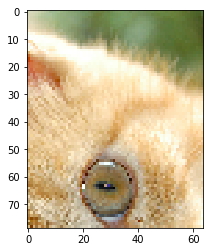

[[[0.00555556 0.01498127 0.99444443 0.6666667 ]]]


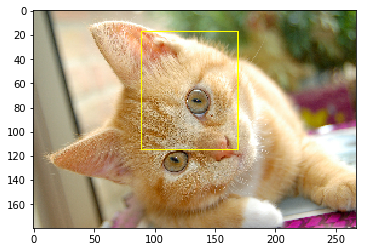

In [38]:
with tf.Session() as sess:         
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    
    # sample_distorted_bounding_box要求输入图片必须是实数类型。
    image_float = tf.image.convert_image_dtype(img_data, tf.float32)
    
    begin, size, bbox_for_draw = tf.image.sample_distorted_bounding_box(
        tf.shape(image_float), bounding_boxes=boxes, min_object_covered=0.4)
   
    # 截取后的图片
    distorted_image = tf.slice(image_float, begin, size)
    plt.imshow(distorted_image.eval())
    plt.show()

    # 在原图上用标注框画出截取的范围。由于原图的分辨率较大（2673x1797)，生成的标注框 
    # 在Jupyter Notebook上通常因边框过细而无法分辨，这里为了演示方便先缩小分辨率。
    image_small = tf.image.resize_images(image_float, [180, 267], method=0)
    batchced_img = tf.expand_dims(image_small, 0)
    image_with_box = tf.image.draw_bounding_boxes(batchced_img, bbox_for_draw)
    print(bbox_for_draw.eval())
    plt.imshow(image_with_box[0].eval())
    plt.show()

### 7.2.2 图像处理的完整样例

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#### 1. 随机调整图片的色彩，定义两种顺序。

In [40]:
def distort_color(image, color_ordering=0):
    if color_ordering == 0:
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    else:
        image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        image = tf.image.random_brightness(image, max_delta=32./255.)
        image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
        image = tf.image.random_hue(image, max_delta=0.2)

    return tf.clip_by_value(image, 0.0, 1.0)

#### 2. 对图片进行预处理，将图片转化成神经网络的输入层数据。|

In [41]:
def preprocess_for_train(image, height, width, bbox):
    # 查看是否存在标注框。
    if bbox is None:
        bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        
    # 随机的截取图片中一个块。
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox, min_object_covered=0.4)
    bbox_begin, bbox_size, _ = tf.image.sample_distorted_bounding_box(
        tf.shape(image), bounding_boxes=bbox, min_object_covered=0.4)
    distorted_image = tf.slice(image, bbox_begin, bbox_size)

    # 将随机截取的图片调整为神经网络输入层的大小。
    distorted_image = tf.image.resize_images(distorted_image, [height, width], method=np.random.randint(4))
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = distort_color(distorted_image, np.random.randint(2))
    return distorted_image

#### 3. 读取图片。

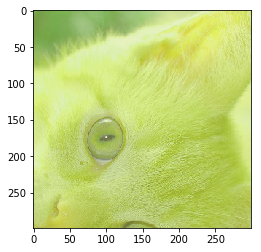

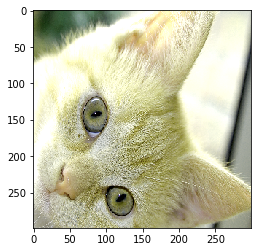

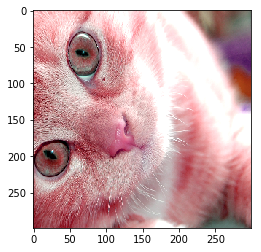

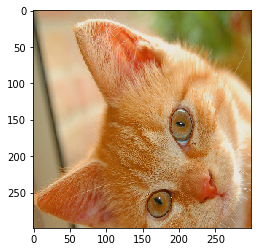

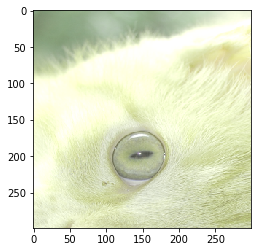

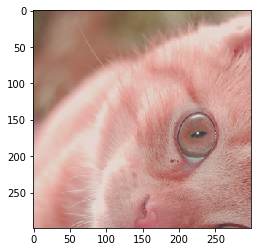

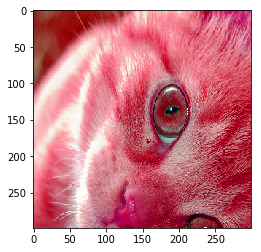

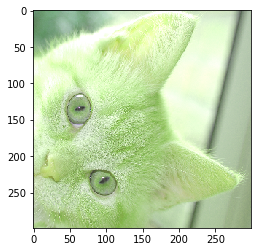

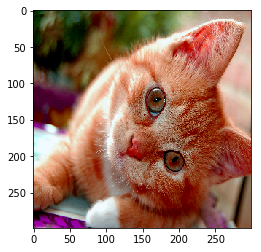

In [42]:
image_raw_data = tf.gfile.FastGFile("../data/cat.jpg", "rb").read()
with tf.Session() as sess:
    img_data = tf.image.decode_jpeg(image_raw_data)
    boxes = tf.constant([[[0.05, 0.05, 0.9, 0.7], [0.35, 0.47, 0.5, 0.56]]])
    for i in range(9):
        result = preprocess_for_train(img_data, 299, 299, boxes)
        plt.imshow(result.eval())
        plt.show()

## 7.3 多线程输入数据处理框架

![1207](../TfInActionImg/1207.PNG)

### 队列与多线程

In [43]:
import tensorflow as tf

#### 1. 创建队列，并操作里面的元素。

In [44]:
q = tf.FIFOQueue(2, "int32")
init = q.enqueue_many(([0, 10],))
x = q.dequeue()
y = x + 1
q_inc = q.enqueue([y])
with tf.Session() as sess:
    init.run()
    for _ in range(5):
        v, _ = sess.run([x, q_inc])
        print v

0
10
1
11
2


#### RandomShuffleQueue会将队列中的元素打乱，每次出队列是从当前队列所有元素中随机选择一个

In [3]:
import numpy as np
import threading
import time

In [12]:
def MyLoop(coord,worker_id):
    while not coord.should_stop():
        if np.random.rand()<0.1:
            print "Stoping from id: %d\n"%worker_id
            coord.request_stop()
        else:
            print "Working on id:%d\n"% worker_id
        # 暂停1秒
        time.sleep(3)
        
coord = tf.train.Coordinator()
threads = [threading.Thread(target=MyLoop, args = (coord,i,)) for i in xrange(5)]
for t in threads:
    t.start()
coord.join(threads)

Working on id:0

Working on id:1

Working on id:2

Working on id:3

Working on id:4

Stoping from id: 0



#### tf.QueueRunner主要用于启动多个线程操作同一个队列

In [19]:
queue  = tf.FIFOQueue(100,"float")
enqueue_op = queue.enqueue([tf.random_normal([1])])
qr = tf.train.QueueRunner(queue,[enqueue_op]*5)

tf.train.add_queue_runner(qr)
out_tensor = queue.dequeue()

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess,coord=coord)
    for _ in range(3):
        print sess.run(out_tensor)[0]
        
    coord.request_stop()
    coord.join(threads)

-0.6601508
-0.9258298
0.550486


### 7.3.2 输入文件队列

#### Tensorflow提供了tf.train.match_filenames_once函数来获取一个正则表达式的所有文件，得到的文件列表可以通过tf.train.string_input_producer函数进行有效管理

#### 先给出一个简单程序生成样例数据

In [11]:
import tensorflow as tf
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
num_shards = 2
instances_per_shard = 2
for i in range(num_shards):
    filename = ('data.tfrecords-%.5d-of-%.5d' % (i, num_shards)) 
    # 将Example结构写入TFRecord文件。
    writer = tf.python_io.TFRecordWriter(filename)
    for j in range(instances_per_shard):
    # Example结构仅包含当前样例属于第几个文件以及是当前文件的第几个样本。
        example = tf.train.Example(features=tf.train.Features(feature={
            'i': _int64_feature(i),
            'j': _int64_feature(j) }))
        writer.write(example.SerializeToString())
    writer.close()  

![1727](../TfInActionImg/1727.PNG)

In [12]:
files = tf.train.match_filenames_once("data.tfrecords-*")
filename_queue = tf.train.string_input_producer(files, shuffle=False) 
reader = tf.TFRecordReader()
_, serialized_example = reader.read(filename_queue)
features = tf.parse_single_example(
      serialized_example,
      features={
          'i': tf.FixedLenFeature([], tf.int64),
          'j': tf.FixedLenFeature([], tf.int64),
      })
with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
    print sess.run(files)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(8):
        print sess.run([features['i'], features['j']])
    coord.request_stop()
    coord.join(threads)

['./data.tfrecords-00000-of-00002' './data.tfrecords-00001-of-00002']
[0, 0]
[0, 1]
[1, 0]
[1, 1]
[0, 0]
[0, 1]
[1, 0]
[1, 1]


### 7.3.3 组合训练数据

In [14]:
example, label = features['i'], features['j']
batch_size = 2
capacity = 1000 + 3 * batch_size
example_batch, label_batch = tf.train.batch([example, label], batch_size=batch_size, capacity=capacity)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(3):
        cur_example_batch, cur_label_batch = sess.run([example_batch, label_batch])
        print cur_example_batch, cur_label_batch
    coord.request_stop()
    coord.join(threads)

[0 0] [0 1]
[1 1] [0 1]
[0 0] [0 1]


### 7.3.4 输入数据的处理框架

#### 1. 创建文件列表，通过文件列表创建输入文件队列，读取文件为本章第一节创建的文件。

In [22]:
files = tf.train.match_filenames_once("output.tfrecords")
filename_queue = tf.train.string_input_producer(files, shuffle=False) 

#### 解析TFRecord文件里的数据。

In [23]:
# 读取文件。

reader = tf.TFRecordReader()
_,serialized_example = reader.read(filename_queue)

# 解析读取的样例。
features = tf.parse_single_example(
    serialized_example,
    features={
        'image_raw':tf.FixedLenFeature([],tf.string),
        'pixels':tf.FixedLenFeature([],tf.int64),
        'label':tf.FixedLenFeature([],tf.int64)
    })

decoded_images = tf.decode_raw(features['image_raw'],tf.uint8)
retyped_images = tf.cast(decoded_images, tf.float32)
labels = tf.cast(features['label'],tf.int32)
#pixels = tf.cast(features['pixels'],tf.int32)
images = tf.reshape(retyped_images, [784])

#### 将文件以100个为一组打包。

In [24]:
min_after_dequeue = 10000
batch_size = 100
capacity = min_after_dequeue + 3 * batch_size

image_batch, label_batch = tf.train.shuffle_batch([images, labels], 
                                                    batch_size=batch_size, 
                                                    capacity=capacity, 
                                                    min_after_dequeue=min_after_dequeue)

#### 训练模型。

In [25]:
def inference(input_tensor, weights1, biases1, weights2, biases2):
    layer1 = tf.nn.relu(tf.matmul(input_tensor, weights1) + biases1)
    return tf.matmul(layer1, weights2) + biases2

In [26]:
# 模型相关的参数
INPUT_NODE = 784
OUTPUT_NODE = 10
LAYER1_NODE = 500
REGULARAZTION_RATE = 0.0001   
TRAINING_STEPS = 5000        

weights1 = tf.Variable(tf.truncated_normal([INPUT_NODE, LAYER1_NODE], stddev=0.1))
biases1 = tf.Variable(tf.constant(0.1, shape=[LAYER1_NODE]))

weights2 = tf.Variable(tf.truncated_normal([LAYER1_NODE, OUTPUT_NODE], stddev=0.1))
biases2 = tf.Variable(tf.constant(0.1, shape=[OUTPUT_NODE]))

y = inference(image_batch, weights1, biases1, weights2, biases2)
    
# 计算交叉熵及其平均值
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=label_batch)
cross_entropy_mean = tf.reduce_mean(cross_entropy)
    
# 损失函数的计算
regularizer = tf.contrib.layers.l2_regularizer(REGULARAZTION_RATE)
regularaztion = regularizer(weights1) + regularizer(weights2)
loss = cross_entropy_mean + regularaztion

# 优化损失函数
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    
# 初始化会话，并开始训练过程。
with tf.Session() as sess:
    # tf.global_variables_initializer().run()
    sess.run((tf.global_variables_initializer(),
              tf.local_variables_initializer()))
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    # 循环的训练神经网络。
    for i in range(TRAINING_STEPS):
        if i % 1000 == 0:
            print("After %d training step(s), loss is %g " % (i, sess.run(loss)))
                  
        sess.run(train_step) 
    coord.request_stop()
    coord.join(threads)       

After 0 training step(s), loss is 594.301 
After 1000 training step(s), loss is 2.71683 
After 2000 training step(s), loss is 2.61916 
After 3000 training step(s), loss is 2.20825 
After 4000 training step(s), loss is 2.42512 


## 7.4 数据集

#### 上一节介绍了通过队列进行多线程输入的方法。除队列以外， TensorFlow 还提供了 一套更高层 的数据处理框架。在新的框架中，每一个数据来源被抽象成一个“数据集”，开发者可以以数据集为基本对象，方便地进行 batching、随机打乱（ shuffle）等操作。从 1.3 版本起， TensorFlow 正式推荐使用数据集作为输入数据的首选框架。从 1.4 版本起，数据集框架从 tf.contrib.data 迁移到 tf.data，成为 TensorFlow 的核心组成部件。

### 

#### 附：